<a href="https://colab.research.google.com/github/jihoover77/DS-Unit-2-Linear-Models/blob/master/Logistic_Regression_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I.  Wrangle my dataset

In [3]:
# Load data downloaded from https://srcole.github.io/100burritos/
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['Date'],
                   index_col='Date',
                   )
  
  # Drop high cardinality columns
  high_card_cols = ['Location','Neighborhood', 'Address', 'URL', 'Reviewer', 'Notes']
  df.drop(columns=high_card_cols, inplace=True)

  # Derive binary classification target:
  # We define a 'Great' burrito as having an
  # overall rating of 4 or higher, on a 5 point scale.
  # Drop unrated burritos.
  df = df.dropna(subset=['overall'])
  df['Great'] = df['overall'] >= 4
  df.drop(columns=['overall'], inplace=True)

  # Clean/combine the Burrito categories
  df['Burrito'] = df['Burrito'].str.lower()

  california = df['Burrito'].str.contains('california')
  asada = df['Burrito'].str.contains('asada')
  surf = df['Burrito'].str.contains('surf')
  carnitas = df['Burrito'].str.contains('carnitas')

  df.loc[california, 'Burrito'] = 'California'
  df.loc[asada, 'Burrito'] = 'Asada'
  df.loc[surf, 'Burrito'] = 'Surf & Turf'
  df.loc[carnitas, 'Burrito'] = 'Carnitas'
  df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

  # Drop some columns to prevent "leakage"
  df = df.drop(columns=['Rec', 'Queso', 'Mass (g)', 'Density (g/mL)'])

  # Change all of the categorical X to x
  categorical_col_names = df.select_dtypes('object').columns
  for col in categorical_col_names:
    df[col] = df[col].str.lower()

  # Change the categorical columns to binary
  for col in categorical_col_names:
    df.loc[df[col] == 'x', col] = 1
  df = df.fillna(0)
 

  return df
df = wrangle(DATA_PATH+'burritos/burritos.csv')

In [4]:
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,california,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,california,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,carnitas,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,asada,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-27,california,4.0,3.8,1,6.59,4.0,0.0,0.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


# II. Split dataset into train/validate/test

In [5]:
# Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018
target = 'Great'
y = df[target]
X = df.drop(columns=target)


X.shape, y.shape


((421, 54), (421,))

In [6]:
cutoff_1 = '2017-01-01'
mask_1 = df.index < cutoff_1
cutoff_2 = '2018-01-01'
mask_2 = (df.index < cutoff_2) & (df.index >= cutoff_1)
mask_3 = df.index > cutoff_2

X_train, y_train = X.loc[mask_1], y.loc[mask_1]
X_val, y_val = X.loc[mask_2], y.loc[mask_2]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

# Create the test set

X_test, y_test = X.loc[mask_3], y.loc[mask_3]

# Establish the baseline accuracy

In [7]:
y.value_counts(normalize=True)

False    0.567696
True     0.432304
Name: Great, dtype: float64

In [8]:
y_baseline = y.value_counts(normalize=True).max()

print(f'Baseline accuracy:  {100 * y_baseline:,.1f}%')

Baseline accuracy:  56.8%


# Build the Model

In [9]:
model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(C=0.005)
)

model.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
print(f'Logistic regression training accuracy:  {100 * model.score(X_train, y_train):,.1f}')
print(f'Logistic regression validation accuracy:  {100 * model.score(X_val, y_val):,.1f}')

Logistic regression training accuracy:  87.6
Logistic regression validation accuracy:  88.2


In [11]:
len(model.named_steps['logisticregression'].coef_.flatten())

59

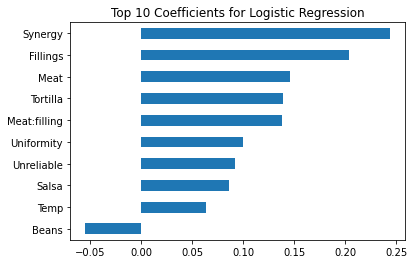

In [12]:
coefficients = model.named_steps['logisticregression'].coef_.flatten()
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.title('Top 10 Coefficients for Logistic Regression');